In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import oracledb

## Notes for group:

- For regression do we only want to use 'response' and year? or include other variables (ie. predict differently for the sources in power generated/consumed or combine all into one prediction? keep as is

- For dataframes with month do we include it? or just summarize to a yearly avg (will do both)

- Some correlation matrices are pretty useless... do we keep all? (I would say yes just to show how year correlates with what we are predicting YES

- On correlation... some of the correlations between year and predictor are ~0... therefore regression model is ineffective. Anything we want to do about that? (Could be just not regressing for that dataset or including other features). No

- Any other plots to include? Could be something just exploratory (histogram of count, etc.) or something related to regression (residuals, CI, etc) histogram

- What do we want to display to summarize regression models? I was thinking R^2 score and the plot of predictions vs true values.

### Reading in and viewing all data frames:

In [5]:
# code from here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql_query.html

dsn = oracledb.makedsn("localhost", 1522, service_name="stu")
connection = oracledb.connect(user="ora_mgillies", password="a59188508", dsn=dsn)
cur = connection.cursor()



In [7]:
# Function to read in data from SQL
def read_data(df_name, con):
    # Parameters:
    # df_name: String -> name of table in SQL to read
    # con: the sql connection from oracle db
    df = pd.read_sql_query("SELECT * FROM " + str(df_name), con)
    return df

In [40]:
earthtemp = read_data('temperature', connection)
earthtemp['Date'] = pd.to_datetime(earthtemp['Date'])
earthtemp['YEAR_TEMP'] = earthtemp['Date'].dt.year
earthtemp.head()

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_13077/1373968916.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM " + str(df_name), con)


,Date,AVGTEMP,AVGTEMPUNC,YEAR_TEMP
0,2005-01-01,-13.081,0.240,2005
1,2005-02-01,-6.682,0.339,2005
2,2005-03-01,-1.717,0.276,2005
3,2005-04-01,2.924,0.162,2005
4,2005-05-01,8.535,0.141,2005


In [55]:
# Need to deal with the total column here
population = read_data('population', connection)
population['TOTAL'] = population['TOTAL'].str.replace(',', '').astype(int)
population.head()

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_13077/1373968916.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM " + str(df_name), con)


,YEAR_POP,REGION,MUNICIPALITY,TOTAL,SOURCE_PG,YEAR_PG,SOURCE_PC,YEAR_PC
0,2009,15022,Vancouver,615216,NATURAL GAS,2009,OIL,2009
1,2009,15022,Vancouver,615216,OIL,2009,OIL,2009
2,2009,15022,Vancouver,615216,BIOMASS,2009,BIOMASS,2009
3,2009,15022,Vancouver,615216,NATURAL GAS,2009,BIOMASS,2009
4,2009,15022,Vancouver,615216,OIL,2009,BIOMASS,2009


In [22]:
powercons=read_data('power_consumed', connection)
powercons.head()

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_13077/1373968916.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM " + str(df_name), con)


,SOURCE_PC,YEAR_PC,VALUE_PC
0,OIL,2006,457.0888
1,NATURAL GAS,2007,321.0989
2,OIL,2009,430.8465
3,BIOMASS,2010,204.5951
4,NATURAL GAS,2010,305.5171


In [23]:
powergen = read_data('power_generated', connection)
powergen.head()

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_13077/1373968916.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM " + str(df_name), con)


,SOURCE_PG,YEAR_PG,VALUE_PG
0,BIOMASS,2006,10.615334
1,NATURAL GAS,2006,8.599036
2,OIL,2006,0.128002
3,BIOMASS,2007,10.615334
4,NATURAL GAS,2007,8.599032


In [24]:
precipitation = read_data('precipitation', connection)
precipitation.head()

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_13077/1373968916.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM " + str(df_name), con)


,STATION,YEAR_P,MONTH,MAXTEMP,MINTEMP,TOTALPREC
0,SAM,2005,6,14.7,8.6,0.0
1,SAM,2005,7,20.1,10.2,0.2
2,SAM,2005,8,19.3,8.3,0.0
3,SAM,2005,9,19.8,11.2,0.1
4,SAM,2005,10,12.6,3.2,1.5


## Exploratory Data Analysis:
For our exploratory data analysis we will view the correlations of the features within each dataset.

In [25]:
# some code from: https://seaborn.pydata.org/generated/seaborn.heatmap.html
def plot_corr(df):
    # Parameters: 
    # df: pd.DataFrame -> the dataframe to be plotted
    # returns a seaborn heatmap representing the correlations of the features
    
    sn.heatmap(df.corr(), cmap = 'magma', annot = True)

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_13077/1175524423.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(df.corr(), cmap = 'magma', annot = True)


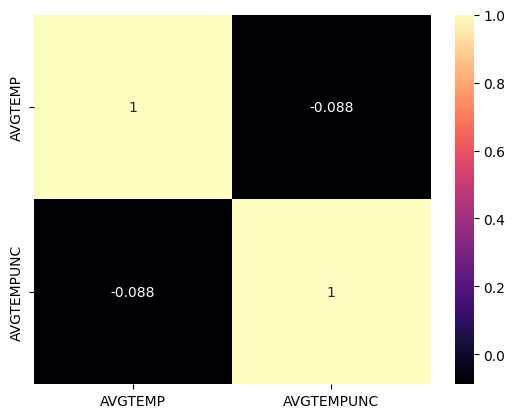

In [26]:
plot_corr(earthtemp)

We see correlation between temperature and month, however there is a near zero correlation between year and temperature. This is about as expected, as we know temperature changes greatly with month. 

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_13077/1175524423.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(df.corr(), cmap = 'magma', annot = True)


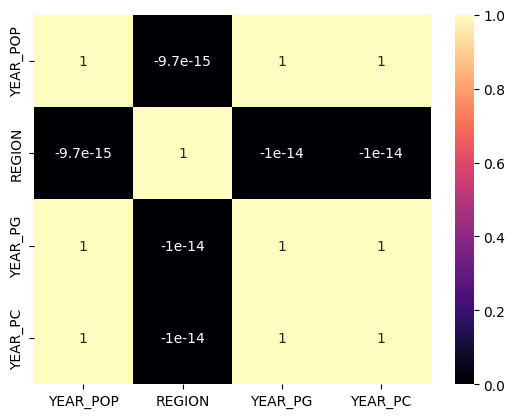

In [27]:
plot_corr(population)

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_13077/1175524423.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(df.corr(), cmap = 'magma', annot = True)


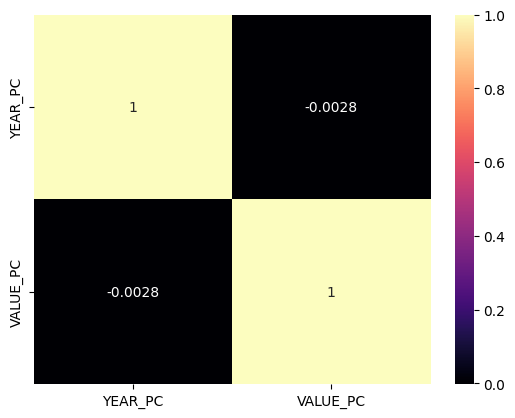

In [28]:
plot_corr(powercons)

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_13077/1175524423.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(df.corr(), cmap = 'magma', annot = True)


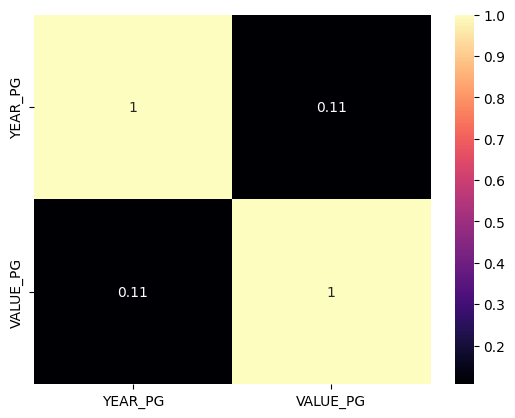

In [29]:
plot_corr(powergen)

/var/folders/h6/_rz_hgwd06q2j4rsml2mr9yr0000gn/T/ipykernel_13077/1175524423.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(df.corr(), cmap = 'magma', annot = True)


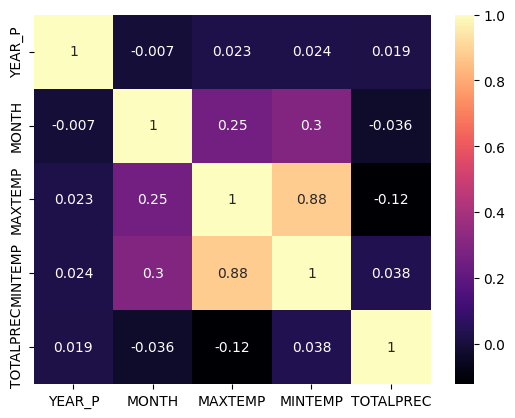

In [30]:
plot_corr(precipitation)

Here we see a meaningful correlation between minimum temperature and maximum temperature. The rest of the dataset provides quite weak correlations besides this. 

In [31]:
def plot_bar(data, cat_column, num_column):
    # Parameters:
    # data: pd.DataFrame -> data frame to plot
    # cat_column: String -> The column name (categorical) to group by
    # num_column: String -> The column name (numerical) to aggregate
    # Returns a matplotlib bar chart
    df_grouped = data.groupby(cat_column).agg({num_column:'mean'})
    plt.bar(df_grouped.index, df_grouped[num_column])
    plt.xlabel(cat_column)
    plt.ylabel(num_column)
    
    

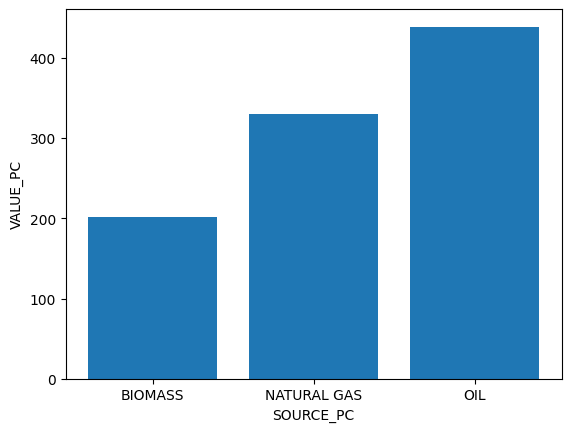

In [34]:
# Plotting power consumed by source
plot_bar(powercons, 'SOURCE_PC', 'VALUE_PC')

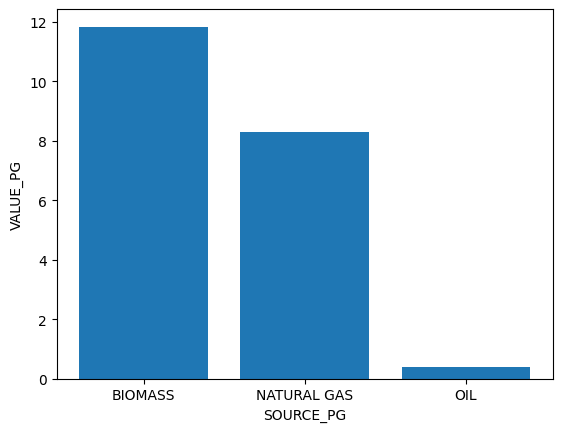

In [35]:
# Plotting power generated by source
plot_bar(powergen, 'SOURCE_PG', 'VALUE_PG')

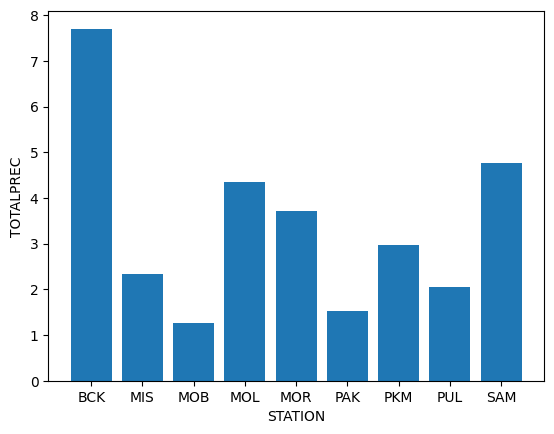

In [37]:
# Plotting average precipitation by station:
plot_bar(precipitation, 'STATION', 'TOTALPREC')

# Analysis:
Performing linear regression on each of the data frames and their response variables, and predicting each up to the year 2030. Then we can compare future results to see if the power generated & consumed is truly sustainable. 

In [46]:
# some code from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
def fit_year_regression_model(data,cov,response):
    # Params: 
    # data: pd.DataFrame -> dataframe to regress on
    # cov: string -> name of covariate
    # response: string -> the name of the response variable 
    # alpha: float -> the value of alpha to use in the Ridge regressor
    
    # Function fits a Ridge regression model to the specified response from Year, returns the fitted model, 
    # the R^2 score and predictions for the years 2014-2030.
    
    ridge = LinearRegression()
    X = data[[cov]]
    y = data[response]
    ridge.fit(X,y)
    
    score = ridge.score(X,y)
    
    new_years = np.arange(2014, 2035, 1).reshape(-1,1)
    preds = ridge.predict(new_years)
    
    return ridge, score, preds

In [47]:
def plot_old_and_preds(data, cov, preds, model, response):
    # Params:
    # data: pd.DataFrame -> data to plot/predict from
    # preds: np.array -> predictions from previous regression model
    # model: LinearRegression instance -> the model fit to the data
    # response: String -> name of response variable
    
    # Function predicts values for years 2005-2035 using the previously fitted model, then plots the predictions
    # against the true values.
    
    # Returns matplotlib plot
    
    years = np.arange(2005, 2035, 1).reshape(-1,1)
    preds = model.predict(years)
    data_years = data[cov].values
    data_vals = data[response].values
    
    plt.plot(years, preds, color = 'blue', label = 'Prediction')
    plt.plot(data_years, data_vals, color = 'red', label = 'Real Data')
    plt.xlabel("Year")
    plt.ylabel(response)
    plt.legend()
    
    plt.show()
    

In [48]:
def group_df_by(df, column, yr):
    # Parameters:
    # df: pd.DataFrame -> dataframe to group
    # column: String -> column name to aggregate
    # yr: String -> the name of the year column in the certain df
    # returns the grouped dataframe
    
    df_grouped = df.groupby(yr).agg({column:'mean'})
    df_grouped = df_grouped.reset_index()
    return df_grouped


In [49]:
# Earth temperature
et_grouped = group_df_by(earthtemp, 'AVGTEMP', 'YEAR_TEMP')

In [52]:
# Fitting temperature model
et_model, et_score, et_preds = fit_year_regression_model(et_grouped, 'YEAR_TEMP', 'AVGTEMP')
et_preds

/Applications/miniconda3/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([2.05582639, 2.19683611, 2.33784583, 2.47885556, 2.61986528,
       2.760875  , 2.90188472, 3.04289444, 3.18390417, 3.32491389,
       3.46592361, 3.60693333, 3.74794306, 3.88895278, 4.0299625 ,
       4.17097222, 4.31198194, 4.45299167, 4.59400139, 4.73501111,
       4.87602083])

/Applications/miniconda3/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


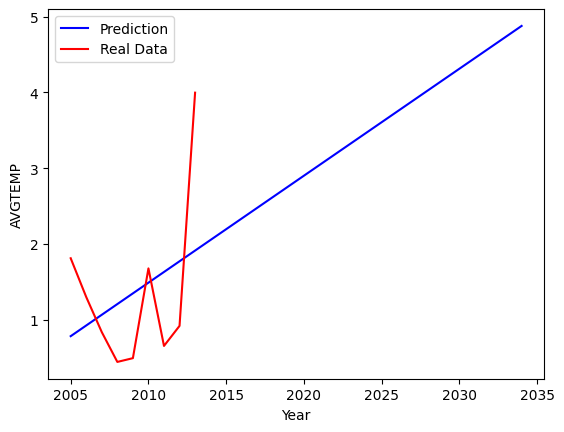

In [53]:
# Plotting temperature model
plot_old_and_preds(et_grouped, 'YEAR_TEMP', et_preds, et_model, 'AVGTEMP')

In [56]:
# Population dataset
pop_grouped = group_df_by(population, 'TOTAL', 'YEAR_POP')
pop_model, pop_score, pop_preds = fit_year_regression_model(pop_grouped, 'YEAR_POP', 'TOTAL')
pop_preds

/Applications/miniconda3/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([171264.54285714, 172893.80238095, 174523.06190476, 176152.32142857,
       177781.58095238, 179410.84047619, 181040.1       , 182669.35952381,
       184298.61904762, 185927.87857143, 187557.13809524, 189186.39761905,
       190815.65714286, 192444.91666667, 194074.17619048, 195703.43571429,
       197332.6952381 , 198961.9547619 , 200591.21428571, 202220.47380952,
       203849.73333333])

/Applications/miniconda3/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


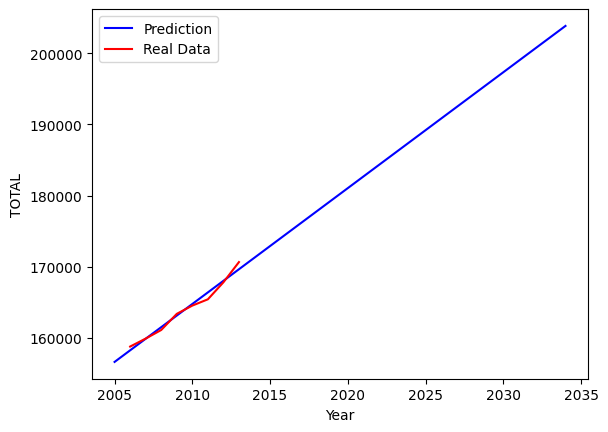

In [57]:
plot_old_and_preds(pop_grouped, 'YEAR_POP', pop_preds, pop_model, 'TOTAL')

In [59]:
# Power Generated dataset
pg_grouped = group_df_by(powergen, 'VALUE_PG', 'YEAR_PG')
pg_model, pg_score, pg_preds = fit_year_regression_model(pg_grouped, 'YEAR_PG', 'VALUE_PG')
pg_preds

/Applications/miniconda3/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([ 7.90837617,  8.14571555,  8.38305492,  8.6203943 ,  8.85773367,
        9.09507305,  9.33241242,  9.56975179,  9.80709117, 10.04443054,
       10.28176992, 10.51910929, 10.75644867, 10.99378804, 11.23112741,
       11.46846679, 11.70580616, 11.94314554, 12.18048491, 12.41782429,
       12.65516366])

/Applications/miniconda3/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


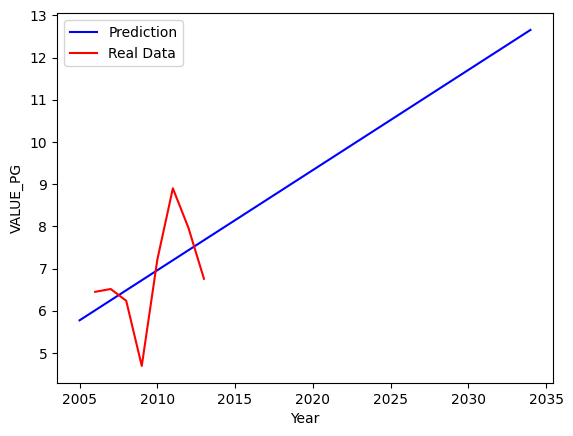

In [60]:
plot_old_and_preds(pg_grouped,'YEAR_PG', pg_preds, pg_model, 'VALUE_PG')

In [63]:
# Power Consumed dataset
pc_grouped = group_df_by(powercons, 'VALUE_PC', 'YEAR_PC')
pc_model, pc_score, pc_preds = fit_year_regression_model(pc_grouped, 'YEAR_PC','VALUE_PC')
pc_preds

/Applications/miniconda3/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([322.90609286, 322.78616905, 322.66624524, 322.54632143,
       322.42639762, 322.30647381, 322.18655   , 322.06662619,
       321.94670238, 321.82677857, 321.70685476, 321.58693095,
       321.46700714, 321.34708333, 321.22715952, 321.10723571,
       320.9873119 , 320.8673881 , 320.74746429, 320.62754048,
       320.50761667])

/Applications/miniconda3/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


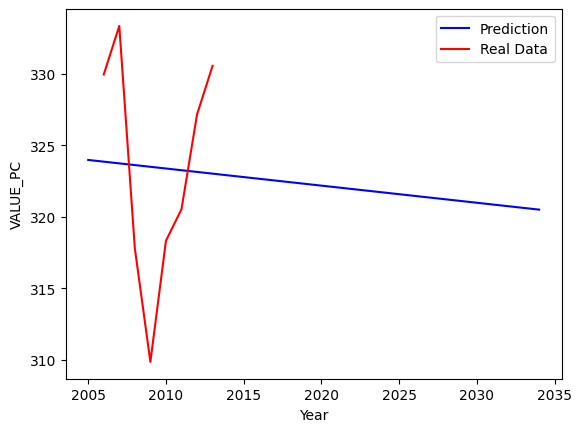

In [64]:
plot_old_and_preds(pc_grouped, 'YEAR_PC',pc_preds, pc_model, 'VALUE_PC')

In [68]:
# Combining predictions and true data in order to compare the trends over time. Here we look at power generated/
# consumed vs population to see if it is 'sustainable'

pop_year_total = pop_grouped[['YEAR_POP', 'TOTAL']]
pop_year_total = pop_year_total.rename(columns = {'TOTAL':'pop_total', 'YEAR_POP':'Year'})
pg_year_total = pg_grouped[['YEAR_PG', 'VALUE_PG']]
pg_year_total = pg_year_total.rename(columns = {'VALUE_PG':'pg_value','YEAR_PG':'Year'})
pc_year_total = pc_grouped[['YEAR_PC', 'VALUE_PC']]
pc_year_total = pc_year_total.rename(columns = {'VALUE_PC':'pc_value','YEAR_PC':'Year'})
pop_pg = pop_year_total.merge(pg_year_total,on = 'Year')
pop_pg_pc = pop_pg.merge(pc_year_total, on = 'Year')
years = np.arange(2014,2035,1)

new_preds_df = pd.DataFrame({'pc_value':pc_preds, 'pg_value':pg_preds, 'pop_total':pop_preds, 'Year':years})

full_df = pd.concat([pop_pg_pc, new_preds_df])
full_df


,Year,pop_total,pg_value,pc_value
0,2006,158761.000000,6.447457,329.967433
1,2007,159881.800000,6.514656,333.369267
2,2008,161091.200000,6.236491,317.791233
3,2009,163360.400000,4.691572,309.843333
4,2010,164522.200000,7.208209,318.321700
5,2011,165405.400000,8.901088,320.536133
6,2012,167798.800000,7.965836,327.163300
7,2013,170642.200000,6.757483,330.573600
0,2014,171264.542857,7.908376,322.906093
1,2015,172893.802381,8.145716,322.786169


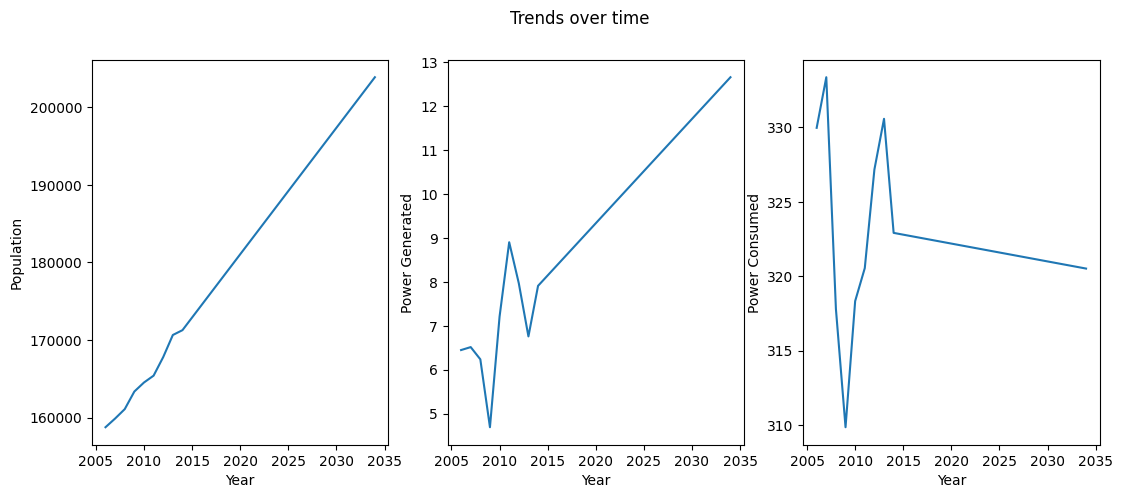

In [79]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (13,5))
plt.subplots_adjust(hspace = 5)
ax0 = axs[0]
ax0.plot(full_df['Year'], full_df['pop_total'])
ax0.set_xlabel("Year")
ax0.set_ylabel("Population")
ax1 = axs[1]
ax1.plot(full_df['Year'], full_df['pg_value'])
ax1.set_xlabel("Year")
ax1.set_ylabel("Power Generated")
ax2 = axs[2]
ax2.plot(full_df['Year'], full_df['pc_value'])
ax2.set_xlabel("Year")
ax2.set_ylabel("Power Consumed")
fig.suptitle("Trends over time")
plt.show()